In [15]:
import numpy as np
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    Resize,
    AddChannel,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import yaml
import sys
sys.path.append("/home/local/VANDERBILT/litz/github/MASILab/lobe_seg")
from dataloader import dataloader
import pandas as pd

In [16]:
def showslice(img, x, y, z, is_gray=False, clip_range=[]):
    clip_sag = img[x, :, :]
    clip_sag = np.flip(clip_sag, 0)
    clip_sag = np.rot90(clip_sag)
    clip_cor = img[:, y, :]
    clip_cor = np.rot90(clip_cor)
    clip_ax = img[:,:,z]
    clip_ax = np.rot90(clip_ax)
    if len(clip_range) > 0:
        vmin = clip_range[0]
        vmax = clip_range[1]
    else:
        vmax = np.max(img)
        vmin = np.min(img)
    # fig = plt.figure(1)
    f, ax= plt.subplots(1,3, figsize=(15,15))
    if is_gray:
        sag = ax[0].imshow(clip_sag, interpolation='nearest', cmap='gray', vmin=vmin, vmax = vmax)
        ax[1].imshow(clip_cor, interpolation='nearest', cmap='gray', vmin=vmin, vmax = vmax)
        ax[2].imshow(clip_ax, interpolation='nearest', cmap='gray', vmin=vmin, vmax = vmax)
    else:
        sag = ax[0].imshow(clip_sag, interpolation='nearest', vmin=vmin, vmax = vmax)
        ax[1].imshow(clip_cor, interpolation='nearest', vmin=vmin, vmax = vmax)
        ax[2].imshow(clip_ax, interpolation='nearest', vmin=vmin, vmax = vmax)
    plt.colorbar(sag, ax=ax[2], fraction=0.046, pad=0.04)
    
def showSag(img, x, is_gray=False, clip_range=[]):
    clip_sag = img[x, :, :]
    clip_sag = np.flip(clip_sag, 0)
    clip_sag = np.rot90(clip_sag)
    if len(clip_range) > 0:
        vmin = clip_range[0]
        vmax = clip_range[1]
    else:
        vmax = np.max(img)
        vmin = np.min(img)
    f = plt.figure(figsize=(20,20))
    if is_gray:
        sag = plt.imshow(clip_sag, interpolation='nearest', cmap='gray', vmin=vmin, vmax = vmax)
    else:
        sag = plt.imshow(clip_sag, interpolation='nearest', vmin=vmin, vmax = vmax)
    plt.colorbar(sag, fraction=0.046, pad=0.04)

def showCor(img, y, is_gray=False, clip_range=[]):
    clip_cor = img[:, y, :]
    clip_cor = np.rot90(clip_cor)
    if len(clip_range) > 0:
        vmin = clip_range[0]
        vmax = clip_range[1]
    else:
        vmax = np.max(img)
        vmin = np.min(img)
    f = plt.figure(figsize=(20,20))
    if is_gray:
        cor = plt.imshow(clip_cor, interpolation='nearest', cmap='gray', vmin=vmin, vmax = vmax)
    else:
        cor = plt.imshow(clip_cor, interpolation='nearest', vmin=vmin, vmax = vmax)
    plt.colorbar(cor, fraction=0.046, pad=0.04)
    
def getSlice(data, x, y, z):
    clip_sag = data[x, :, :]
    clip_sag = np.flip(clip_sag, 0)
    clip_sag = np.rot90(clip_sag)
    clip_cor = data[:, y, :]
    clip_cor = np.rot90(clip_cor)
    clip_ax = data[:,:,z]
    clip_ax = np.rot90(clip_ax)
    return clip_sag, clip_cor, clip_ax

In [11]:
CONFIG_PATH = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/configs/Config_0301.YAML"

In [12]:
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
    return config

config = load_config(CONFIG_PATH)

# unwrap directory paths
MODEL_DIR = config["model_dir"]
TMP_DIR = config["tmp_dir"]

# Load data
train_loader, val_loader = dataloader(config)

# Hyperparams
# N_SAMPLE = config["sample_size"]
LR = config["lr"]
EPOCHS = config["epochs"]
VAL_INTERVAL = config["val_interval"]  # Interval at which to compute validation metrics
NUM_CLASSES = 6
LABEL_SHAPE = (512, 512, 320)  # All labels have this shape, but input shapes vary

# Initialize Model, Loss, and Optimizer
set_determinism(seed=config["random_seed"])
device = torch.device("cuda:1")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=NUM_CLASSES,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
dice_metric = DiceMetric(include_background=False, reduction="mean")

Training sample size: 1089
Validation sample size: 120


In [30]:
metrics_path = os.path.join(config['log_dir'], config["config_id"], f"{config['config_id']}_loss")
epochs = []
dice = []
loss = []
with open(metrics_path) as file:
    for line in file:
        line = line.rstrip()
        l = line.split(",")
        epochs.append(int(l[0]))
        dice.append(float(l[1]))
        loss.append(float(l[2]))

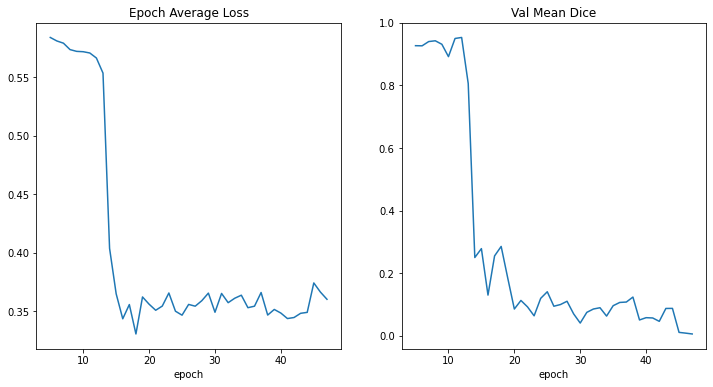

In [31]:
# Plot training loss and validation dice 
metrics_path = os.path.join(config['log_dir'], config["config_id"], f"{config['config_id']}_loss.npy")
# pd.read_csv()

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
plt.plot(epochs, loss)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(epochs, dice)
plt.show()

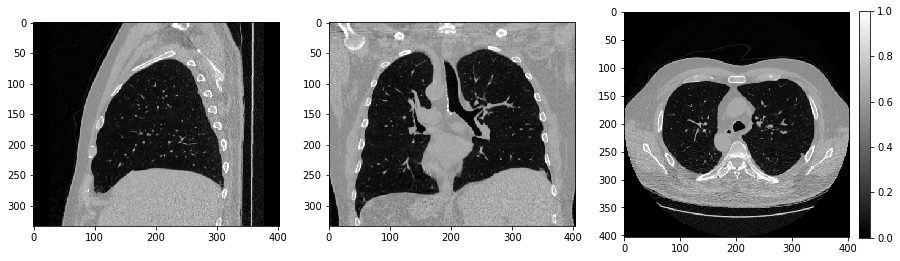

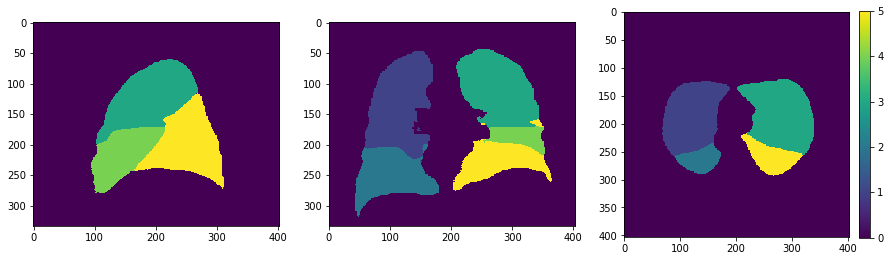

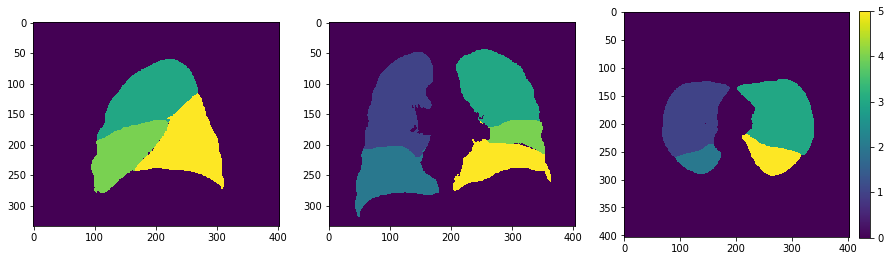

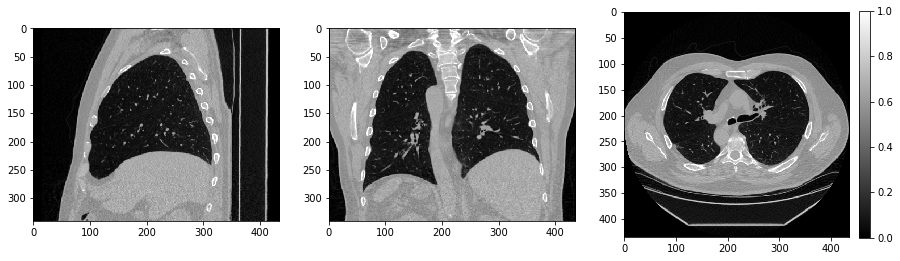

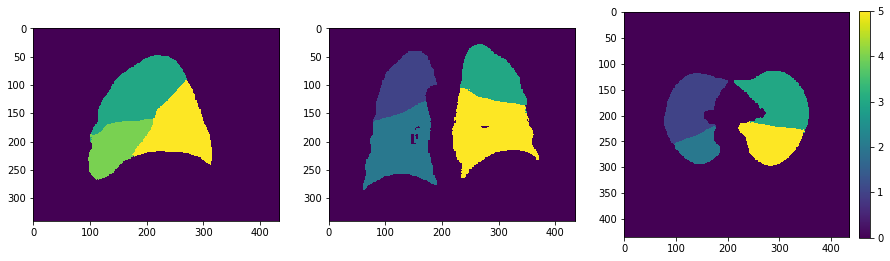

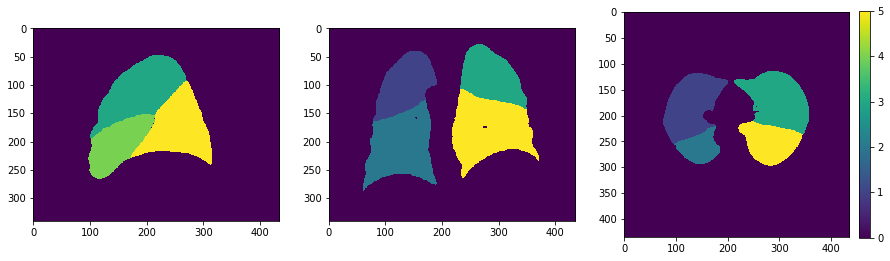

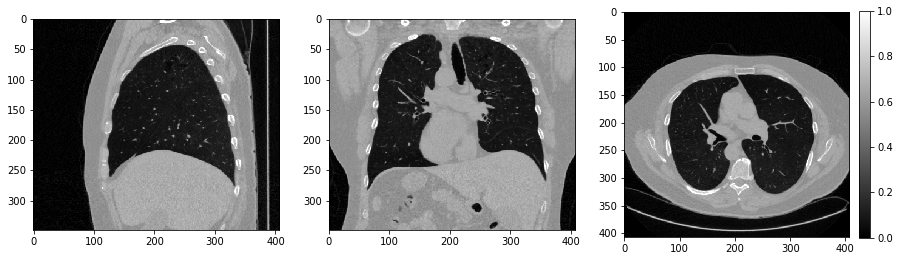

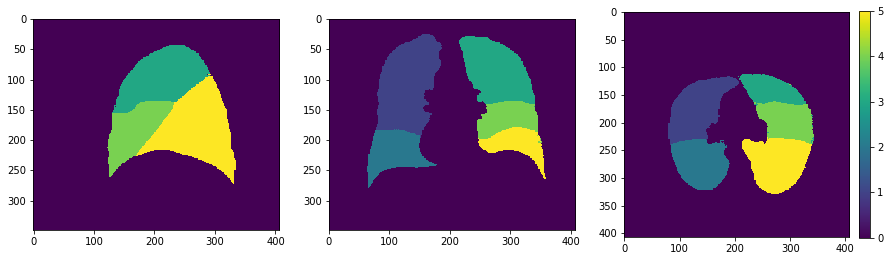

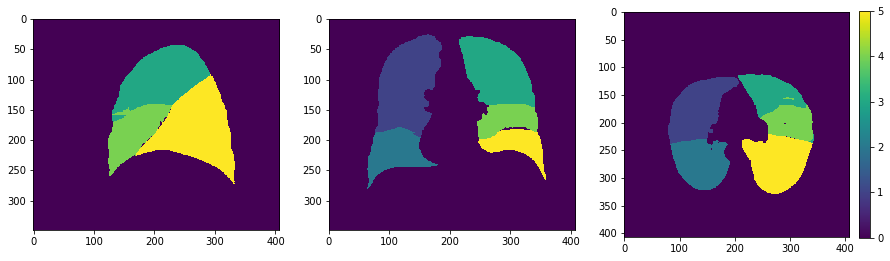

In [14]:
model.load_state_dict(torch.load(os.path.join(config['model_dir'], f"193_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        np_img = val_data["image"][0,0,:,:,:].detach().cpu().numpy()
        np_label = val_data["label"][0,0,:,:,:].detach().cpu().numpy()
        # print(np_img.shape)
        # print(np_label.shape)
        # plt.subplot(1,3,1)
        showslice(np_img, 300, 200,200, is_gray=True)
        # plt.subplot(1,3,2)
        showslice(np_label, 300, 200, 200)
        # plt.subplot(1,3,3)
        output = torch.argmax(val_outputs, dim=1)[0,:,:,:].detach().cpu().numpy()
        # print(output.shape)
        showslice(output, 300, 200,200)
        plt.show()
        if i==2:
            break